In [1]:
import torch
from torch import nn
import torchvision
import torchvision.transforms as transforms

from torch.utils.data import random_split, DataLoader
from torchsummary import summary

from torch.utils.tensorboard import SummaryWriter

import matplotlib.pyplot as plt

In [2]:
torch.cuda.is_available(), torch.__version__

(True, '2.9.1+cu130')

In [3]:
if torch.cuda.is_available():
    current_device_idx = torch.cuda.current_device()
    device_properties = torch.cuda.get_device_properties(current_device_idx)
    print(f"Device Properties: {device_properties}")

Device Properties: _CudaDeviceProperties(name='NVIDIA GeForce RTX 5060 Ti', major=12, minor=0, total_memory=15842MB, multi_processor_count=36, uuid=277ff69b-c475-efe9-d27e-ab49e8a0c81c, pci_bus_id=1, pci_device_id=0, pci_domain_id=0, L2_cache_size=32MB)


In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
# tranformation from pixel to tensors
transform = transforms.ToTensor()

In [6]:
# Download train data from open datasets.
train_full_dataset = torchvision.datasets.FashionMNIST(root='data', train=True, download=True, transform=transform)

# train and validation size
train_size = int(0.83 * len(train_full_dataset))
val_size = len(train_full_dataset) - train_size

train_dataset, val_dataset = random_split(train_full_dataset, [train_size, val_size])

# Download test data from open datsets.
test_dataset = torchvision.datasets.FashionMNIST(root='data', train=False, download=True, transform=transform)

In [7]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

In [8]:
# convert to pytorch dataloader type
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


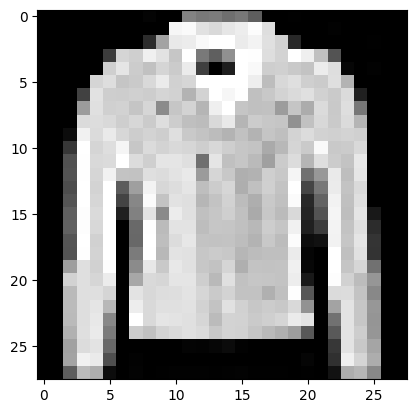

Label: Coat


In [9]:
train_features, train_labels = next(iter(train_dataloader))
print(f'Feature batch shape: {train_features.size()}')
print(f'Labels batch shape: {train_labels.size()}')
img = train_features[1].squeeze()
label = train_labels[1]
plt.imshow(img, cmap='gray')
plt.show()
print(f'Label: {labels_map[label.item()]}')

In [10]:
# Neural network model
class NNetwork_1(nn.Module):
    def __init__(self):
        super(NNetwork_1, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 264),
            nn.ReLU(),
            nn.Linear(264, 128),
            nn.ReLU(),
            nn.Linear(128, 84),
            nn.ReLU(),
            nn.Linear(84, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [11]:
model = NNetwork_1().to(device)

In [12]:
out = summary(model, input_size=(1,28,28))

Layer (type:depth-idx)                   Param #
├─Flatten: 1-1                           --
├─Sequential: 1-2                        --
|    └─Linear: 2-1                       401,920
|    └─ReLU: 2-2                         --
|    └─Linear: 2-3                       135,432
|    └─ReLU: 2-4                         --
|    └─Linear: 2-5                       33,920
|    └─ReLU: 2-6                         --
|    └─Linear: 2-7                       10,836
|    └─ReLU: 2-8                         --
|    └─Linear: 2-9                       850
Total params: 582,958
Trainable params: 582,958
Non-trainable params: 0


In [13]:
# writer for runs
writer = SummaryWriter(log_dir='runs/experiments_1')

In [14]:
# hyperparameters, loss and optimizer
lr = 1e-3
epochs = 50

loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=lr)

In [15]:
train_losses = []
val_losses = []
val_accuracies = []


# training loop
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    total_loss = 0
    for batch, (x,y) in enumerate(dataloader):
        x, y = x.to(device), y.to(device)

        # compute error
        prediction = model(x)
        loss = loss_fn(prediction, y)

        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        if batch % 100 == 0:
            loss, current = loss.item(), batch*len(x)
            print(f"Loss: {loss:>7f} [{current:>5d}/{size:>5d}]")
    avg_train_loss = total_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)

In [16]:
# evaluating loop
def evaluate_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    val_loss, correct = 0, 0
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            pred = model(x)
            val_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    val_loss /= num_batches
    # correct /= size
    val_acc = correct / size
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    print(f"Val Error: \n Val Accuracy: {(100*val_acc):>0.1f}%, Avg. Loss: {val_loss:8f} \n")

In [17]:
for i in range(epochs):
    print(f"Epoch: {i+1}\n-----------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    evaluate_loop(val_dataloader, model, loss_fn)
    evaluate_loop(test_dataloader, model, loss_fn)

     # Log to TensorBoard
    writer.add_scalar("Loss/train", train_losses[-1], i)
    writer.add_scalar("Loss/val", val_losses[-1], i)
    writer.add_scalar("Accuracy/val", val_accuracies[-1], i)

Epoch: 1
-----------------------
Loss: 2.307312 [    0/49800]
Loss: 2.307492 [ 6400/49800]
Loss: 2.308792 [12800/49800]
Loss: 2.284133 [19200/49800]
Loss: 2.307141 [25600/49800]
Loss: 2.305322 [32000/49800]
Loss: 2.295066 [38400/49800]
Loss: 2.298734 [44800/49800]
Val Error: 
 Val Accuracy: 9.9%, Avg. Loss: 2.302829 

Val Error: 
 Val Accuracy: 10.0%, Avg. Loss: 2.302195 

Epoch: 2
-----------------------
Loss: 2.306199 [    0/49800]
Loss: 2.299148 [ 6400/49800]
Loss: 2.298093 [12800/49800]
Loss: 2.310040 [19200/49800]
Loss: 2.298303 [25600/49800]
Loss: 2.303926 [32000/49800]
Loss: 2.301403 [38400/49800]
Loss: 2.294921 [44800/49800]
Val Error: 
 Val Accuracy: 9.9%, Avg. Loss: 2.299227 

Val Error: 
 Val Accuracy: 10.0%, Avg. Loss: 2.298640 

Epoch: 3
-----------------------
Loss: 2.300841 [    0/49800]
Loss: 2.304654 [ 6400/49800]
Loss: 2.306796 [12800/49800]
Loss: 2.299868 [19200/49800]
Loss: 2.289589 [25600/49800]
Loss: 2.290982 [32000/49800]
Loss: 2.301410 [38400/49800]
Loss: 2.2907

In [18]:
evaluate_loop(test_dataloader, model, loss_fn)

Val Error: 
 Val Accuracy: 77.6%, Avg. Loss: 0.620032 



In [19]:
# prediction
model.eval()

x, y = test_dataset[1][0], test_dataset[1][1]

# Add batch dimension and move only x to device
x = x.unsqueeze(0).to(device)

with torch.no_grad():
    pred = model(x)
    pred_y = pred.argmax(1).item()  # highest logit = predicted class index
    predicted, actual = labels_map[pred_y], labels_map[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Pullover", Actual: "Pullover"


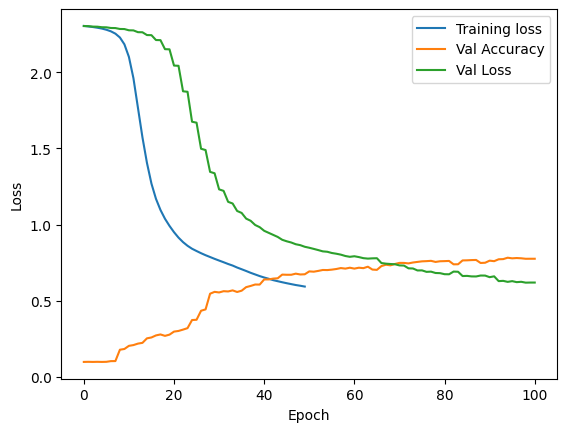

In [20]:
# visualising
fig = plt.Figure(figsize=(12,10))
plt.plot(train_losses, label='Training loss')
plt.plot(val_accuracies, label='Val Accuracy')
plt.plot(val_losses, label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
!tensorboard --logdir=runs


TensorFlow installation not found - running with reduced feature set.

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.20.0 at http://localhost:6006/ (Press CTRL+C to quit)
